In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, Multiply, Input
from keras.models import Model
from keras.optimizers import Adam



In [2]:
import tensorflow as tf
print(tf.__version__)


2.16.2


In [3]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 16
dropout = 0.01
epoch=60
#读取数据
df1=pd.read_csv('data.csv') 
df1=df1.iloc[:,2:]
df1.tail()

,open,low,close,high
26272,7.1042,7.1042,7.1048,7.1055
26273,7.1047,7.1038,7.1038,7.1047
26274,7.1039,7.1039,7.1046,7.1047
26275,7.1048,7.1043,7.1045,7.1049
26276,7.1049,7.1049,7.1057,7.1057


In [4]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
input_size=len(df.iloc[1,:])

In [5]:
#构建lstm输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.to_numpy() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23644, 5, 4) (23644,) (2627, 5, 4) (2627,)


In [6]:
#建立LSTM模型

inputs=Input(shape=(window, input_size))
model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
model=MaxPooling1D(pool_size = window)(model)#池化层
model=Dropout(dropout)(model)#droupout层
model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)#双向LSTM层
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 16)     │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 16)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 16)     │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 32)        │      4,224 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 32)        │      1,056 │ bilstm[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32)        │          0 │ bilstm[0][0],     │
│                     │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ multiply[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,393 (21.07 KB)

 Trainable params: 5,393 (21.07 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history=model.fit(X_train, y_train, epochs=epoch, batch_size = 256,shuffle=False,validation_data=(X_test, y_test)) #训练模型epoch次

Epoch 1/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 2.1302e-04 - loss: 0.1164 - val_accuracy: 0.0000e+00 - val_loss: 0.0574
Epoch 2/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 2.1302e-04 - loss: 0.0843 - val_accuracy: 0.0000e+00 - val_loss: 0.0558
Epoch 3/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.1302e-04 - loss: 0.0794 - val_accuracy: 0.0000e+00 - val_loss: 0.0527
Epoch 4/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 2.1302e-04 - loss: 0.0753 - val_accuracy: 0.0000e+00 - val_loss: 0.0504
Epoch 5/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 2.1302e-04 - loss: 0.0713 - val_accuracy: 0.0000e+00 - val_loss: 0.0481
Epoch 6/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.7455e-04 - loss: 0.0674 - val_accuracy: 0.0000e+00 - val_loss: 0.0459
Epoch 7/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.7455e-04 - loss: 0.0627 - val_accuracy: 0.0000e+00 - val_loss: 0.0435
Epoch 8/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

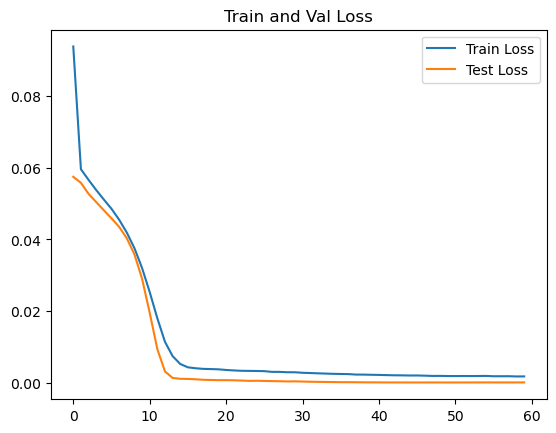

In [8]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Text(0.5, 1.0, 'Train Data')

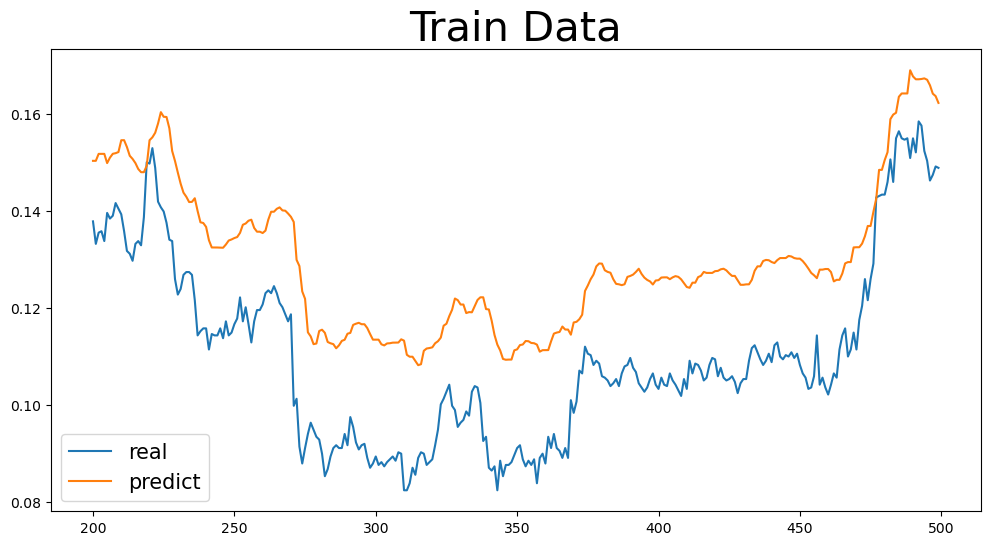

In [9]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 1.0, 'Test Data')

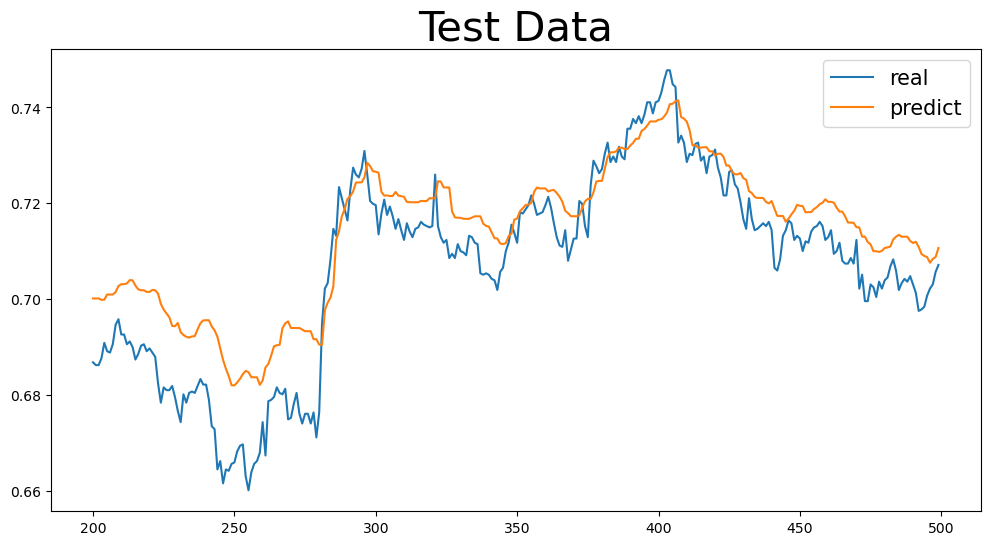

In [10]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [11]:
#输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))
print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.02579200576476441
0.001054278725688532
6.258857189571525
0.4239732690436916
测试集上的MAE/MSE/MAPE/涨跌准确率
0.010653006300480064
0.0001687650132151061
1.4935168832793146
0.3926123381568926


In [15]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
# 训练集 R² 和 Pearson 相关系数
r2_train = r2_score(y_train, y_train_predict)
pearson_train, _ = pearsonr(y_train, y_train_predict)

# 测试集 R² 和 Pearson 相关系数
r2_test = r2_score(y_test, y_test_predict)
pearson_test, _ = pearsonr(y_test, y_test_predict)

# 输出结果
print(f"训练集上的 R²: {r2_train:.4f}")
print(f"训练集上的 Pearson 相关系数: {pearson_train:.4f}")
print(f"测试集上的 R²: {r2_test:.4f}")
print(f"测试集上的 Pearson 相关系数: {pearson_test:.4f}")
import numpy as np

# 计算训练集 RMSEC
rmsec = np.sqrt(np.mean((y_train - y_train_predict) ** 2))

# 计算测试集 RMSEP
rmsep = np.sqrt(np.mean((y_test - y_test_predict) ** 2))

# 输出结果
print(f"训练集上的 RMSEC: {rmsec:.4f}")
print(f"测试集上的 RMSEP: {rmsep:.4f}")
# 对 R² 开根号
r2_train_sqrt = np.sqrt(r2_train)
r2_test_sqrt = np.sqrt(r2_test)

# 输出结果
print(f"训练集上的 R² 开根号: {r2_train_sqrt:.4f}")
print(f"测试集上的 R² 开根号: {r2_test_sqrt:.4f}")



训练集上的 R²: 0.9800
训练集上的 Pearson 相关系数: 0.9928
测试集上的 R²: 0.8839
测试集上的 Pearson 相关系数: 0.9866
训练集上的 RMSEC: 0.0325
测试集上的 RMSEP: 0.0130
训练集上的 R² 开根号: 0.9900
测试集上的 R² 开根号: 0.9402
